In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Import libraries

In [2]:
# import libraries
import numpy as np
import pandas as pd
import random
import os

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# text work
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.layers import Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
train_df = pd.read_csv('../input/nlp-getting-started/train.csv')
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')

## EDA

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df.shape

(7613, 5)

<AxesSubplot:ylabel='target'>

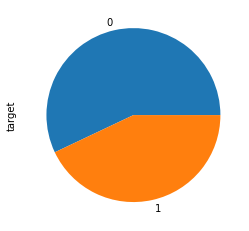

In [6]:
train_df['target'].value_counts().plot(kind='pie')

In [7]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [8]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### drop useless feature

In [9]:
train_df = train_df.drop('location', axis=1)

In [10]:
train_df = train_df.drop('keyword', axis=1)

In [11]:
train_df = train_df.drop('id', axis=1)
train_df

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


### Clean the text

In [12]:
ps = PorterStemmer()
def preprocess_data(data):
    review = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',data) # remove URL
    review = re.sub(r'<.*>',' ',review) # remove HTML tags
    review = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',review)
    review = re.sub('[^a-zA-Z]',' ',review) # filtering out miscellaneous text.
    review = review.lower()
    review = review.split()
    review = [ps.stem(words) for words in review if words not in stopwords.words('english') and words.isalpha()]
    review = ' '.join(review)
    return review

In [13]:
train_df['text2']= train_df['text'].apply(preprocess_data)

In [14]:
train_df = train_df.drop('text', axis=1)


### Token the text

In [15]:
tokenizer = Tokenizer(num_words=2500, split=' ')
tokenizer.fit_on_texts(train_df['text2'].values)
token = tokenizer.texts_to_sequences(train_df['text2'].values)
token = pad_sequences(token)

In [16]:

def token_the_text(text):
    token = tokenizer.texts_to_sequences(text.values)
    token = pad_sequences(token)
    return token

In [17]:
y = train_df['target']
X = train_df['text2']
X_train, X_valid, y_train, y_valid = train_test_split(
    X, 
    y, 
    test_size=0.20, 
    random_state=777)

In [18]:
X_train_token = token_the_text(X_train)
X_valid_token = token_the_text(X_valid)

## Build the Model (LSTM)

In [19]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [20]:
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()



with strategy.scope():
    model_LSTM = Sequential()
    model_LSTM.add(Embedding(3000, 150, input_length = 30))
    model_LSTM.add(Bidirectional(LSTM(128)))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(256, activation='relu'))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(1, activation='sigmoid'))
    

    model_LSTM.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
    model_LSTM.summary()

2022-10-08 12:32:12.009341: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 150)           450000    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               285696    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 801,745
Trainable params: 801,745
Non-trainable params: 0
__________________________________________________

In [21]:
X_train.shape

(6090,)

In [22]:
LSTM_h = model_LSTM.fit(X_train_token, 
                      y_train, 
                      epochs=20,
                      verbose=0,
                      batch_size=16,
                      steps_per_epoch= 1000,
                      validation_data=(X_valid_token, y_valid),
                      validation_freq = 1)

2022-10-08 12:32:12.790763: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [23]:
LSTM_h.history

{'loss': [0.3996724784374237,
  0.20735374093055725,
  0.11647886037826538,
  0.08384498208761215,
  0.06556456536054611,
  0.06076861545443535,
  0.05634380131959915,
  0.05340893939137459],
 'accuracy': [0.821803867816925,
  0.9102740287780762,
  0.946772575378418,
  0.9617069363594055,
  0.966775119304657,
  0.9711658954620361,
  0.9748467206954956,
  0.9747678637504578],
 'val_loss': [0.525156557559967,
  1.0884276628494263,
  1.3230992555618286,
  1.639102816581726,
  1.868595004081726,
  1.7915654182434082,
  1.992299199104309,
  2.040698289871216],
 'val_accuracy': [0.7747865915298462,
  0.7557452321052551,
  0.7564018368721008,
  0.7498358488082886,
  0.7550886273384094,
  0.7426132559776306,
  0.7458962798118591,
  0.7432698607444763]}

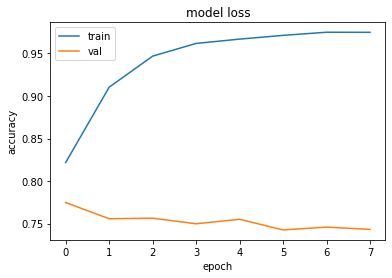

In [25]:

plt.plot(LSTM_h.history['accuracy'])
plt.plot(LSTM_h.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Clean the test text

In [26]:

test_df = test_df.drop('keyword', axis=1)
test_df = test_df.drop('location', axis=1)
test_df = test_df.drop('id', axis=1)
test_df['text2']= test_df['text'].apply(preprocess_data)

In [28]:
test_df = test_df.drop('text', axis=1)

In [48]:
test_token = token_the_text(test_df['text2'])

Predict

In [50]:
predict = model_LSTM.predict(test_token)

In [56]:
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
submission["target"] = predict
submission["target"] = submission["target"].apply(lambda x : 0 if x<=.5 else 1)

In [57]:
submission


,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [58]:
submission.to_csv("submission.csv", index=False)